In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html"

response = requests.get(url)
html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")
weather_table = soup.find("table", attrs={"id": "weather_records"})

dates = []
temperatures = []
descriptions = []

rows = weather_table.find_all("tr")

for row in rows[1:]:
    cols = row.find_all("td")
    cols = [col.text.strip() for col in cols]
    dates.append(cols[0])
    temperatures.append(cols[1])
    descriptions.append(cols[2])


weather_records = pd.DataFrame(
    {"Date and time": dates, "Temperature": temperatures, "Description": descriptions}
)

print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


## Trabajar con bases de datos

**Ejercicio 1**

Imprime el campo company_name. Encuentra la cantidad de viajes en taxi para cada compañía de taxis para el 15 y 16 de noviembre de 2017, asigna al campo resultante el nombre trips_amount e imprímelo también. Ordena los resultados por el campo trips_amount en orden descendente.

In [ ]:
SELECT c.company_name, COUNT(t.trip_id) AS trips_amount
FROM cabs c
JOIN trips t ON c.cab_id = t.cab_id
WHERE DATE(t.start_ts) IN ('2017-11-15', '2017-11-16')
GROUP BY c.company_name
ORDER BY trips_amount DESC;

**Ejercicio 2**

Encuentra la cantidad de viajes para cada empresa de taxis cuyo nombre contenga las palabras "Yellow" o "Blue" del 1 al 7 de noviembre de 2017. Nombra la variable resultante trips_amount. Agrupa los resultados por el campo company_name.

In [ ]:
SELECT c.company_name, COUNT(t.trip_id) AS trips_amount
FROM cabs c
JOIN trips t ON c.cab_id = t.cab_id
WHERE DATE(t.start_ts) BETWEEN '2017-11-01' AND '2017-11-07'
AND (c.company_name LIKE '%Yellow%' OR c.company_name LIKE '%Blue%')
GROUP BY c.company_name;


**Ejercicio 3**

Del 1 al 7 de noviembre de 2017, las empresas de taxis más populares fueron Flash Cab y Taxi Affiliation Services. Encuentra el número de viajes de estas dos empresas y asigna a la variable resultante el nombre trips_amount. Junta los viajes de todas las demás empresas en el grupo "Other". Agrupa los datos por nombres de empresas de taxis. Asigna el nombre company al campo con nombres de empresas de taxis. Ordena el resultado en orden descendente por trips_amount.

In [ ]:
SELECT 
    CASE 
        WHEN c.company_name IN ('Flash Cab', 'Taxi Affiliation Services') THEN c.company_name 
        ELSE 'Other' 
    END AS company,
    COUNT(t.trip_id) AS trips_amount
FROM 
    cabs c
JOIN 
    trips t ON c.cab_id = t.cab_id
WHERE 
    DATE(t.start_ts) BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY 
    CASE 
        WHEN c.company_name IN ('Flash Cab', 'Taxi Affiliation Services') THEN c.company_name 
        ELSE 'Other' 
    END
ORDER BY 
    trips_amount DESC;


**Ejercicio 4**

Recupera los identificadores de los barrios de O'Hare y Loop de la tabla neighborhoods.

In [ ]:
SELECT neighborhood_id, name
FROM neighborhoods
WHERE name LIKE '%Hare' OR name LIKE 'Loop';

**Ejercicio 5**

Para cada hora recupera los registros de condiciones meteorológicas de la tabla weather_records. Usando el operador CASE, divide todas las horas en dos grupos: Bad si el campo description contiene las palabras rain o storm, y Good para los demás. Nombra el campo resultante weather_conditions. La tabla final debe incluir dos campos: fecha y hora (ts) y weather_conditions.

In [ ]:
SELECT 
    w.ts AS date_and_time,
    CASE 
        WHEN w.description LIKE '%rain%' OR w.description LIKE '%storm%' THEN 'Bad' 
        ELSE 'Good' 
    END AS weather_conditions
FROM 
    weather_records w;


**Ejercicio 6**

Recupera de la tabla de trips todos los viajes que comenzaron en el Loop (pickup_location_id: 50) el sábado y terminaron en O'Hare (dropoff_location_id: 63). Obtén las condiciones climáticas para cada viaje. Utiliza el método que aplicaste en la tarea anterior. Recupera también la duración de cada viaje. Ignora los viajes para los que no hay datos disponibles sobre las condiciones climáticas.

Las columnas de la tabla deben estar en el siguiente orden:

- start_ts
- weather_conditions
- duration_seconds

Ordena por trip_id.

In [ ]:
SELECT
    t.start_ts,
    CASE
        WHEN w.description LIKE '%rain%' OR w.description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions,
    t.duration_seconds
FROM
    trips t
INNER JOIN neighborhoods n ON t.pickup_location_id = n.neighborhood_id
INNER JOIN weather_records w ON DATE_TRUNC('hour', t.start_ts) = DATE_TRUNC('hour', w.ts)
WHERE
    n.name = 'Loop'
    AND EXTRACT(DOW FROM t.start_ts) = 6
    AND t.dropoff_location_id = 63
ORDER BY
    t.trip_id;


## Análisis exploratorios de datos con PYTHON



In [ ]:
# Importar todas las librerías utilizadas
import pandas as pd
import matplotlib.pyplot as plt

In [11]:

# Importar los archivos CSV
df_company_trips = pd.read_csv("data_proyecto7/moved_project_sql_result_01.csv")
df_dropoff_locations = pd.read_csv("data_proyecto7/moved_project_sql_result_04.csv")


# Mostrar las primeras filas para verificar la importación

print(df_company_trips.head())

print(df_dropoff_locations.head())

                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299
  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000


In [12]:
# Visualizar algunas estadísticas descriptivas para entender la distribución de los datos
print("\nEstadísticas descriptivas de df_company_trips:")
print(df_company_trips.describe())

print("\nEstadísticas descriptivas de df_dropoff_locations:")
print(df_dropoff_locations.describe())

# Asegurarse de que los tipos de datos sean correctos
print("\nTipos de datos de df_company_trips:")
print(df_company_trips.dtypes)

print("\nTipos de datos de df_dropoff_locations:")
print(df_dropoff_locations.dtypes)


Estadísticas descriptivas de df_company_trips:
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000

Estadísticas descriptivas de df_dropoff_locations:
       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667

Tipos de datos de df_company_trips:
company_name    object
trips_amount     int64
dtype: object

Tipos de datos de df_dropoff_locations:
dropoff_location_name     object
average_trips            float64
dtype: object


### Análisis:

Para el DataFrame `df_company_trips`:
- La cantidad de viajes (`trips_amount`) tiene un promedio de aproximadamente 2145 viajes, con una desviación estándar bastante alta de alrededor de 3812. Esto indica que hay una gran variabilidad en la cantidad de viajes entre las diferentes compañías de taxis.
- El mínimo número de viajes es 2 y el máximo es 19558, lo que muestra la amplia gama de actividad entre las empresas de taxis durante esos dos días.
- La mediana (50% de los datos) es 178.5 viajes, lo que indica que la mitad de las compañías de taxis tienen menos de esta cantidad de viajes y la otra mitad tienen más.

Para el DataFrame `df_dropoff_locations`:
- El promedio de viajes (`average_trips`) que finalizan en cada barrio es de alrededor de 599.95 viajes, pero la desviación estándar es alta (1714.59), lo que sugiere una variabilidad significativa en el número de viajes entre los diferentes barrios.
- El mínimo número de viajes en un barrio es 1.8 y el máximo es 10727.47, lo que muestra una amplia disparidad en la popularidad de los barrios como destinos finales de viaje.
- La mediana es de aproximadamente 52 viajes, lo que indica que la mitad de los barrios tienen menos de esta cantidad de viajes como promedio y la otra mitad tienen más.

En cuanto a los tipos de datos, ambos DataFrames tienen los tipos adecuados para las columnas respectivas (`object` para nombres y `int64` / `float64` para cantidades). Los datos parecen estar en buen estado y listos para un análisis más detallado y la creación de gráficos.

In [13]:
# Identficaremos los 10 principales barrios

top_10_barrios = df_dropoff_locations.head(10)
print(top_10_barrios)

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667


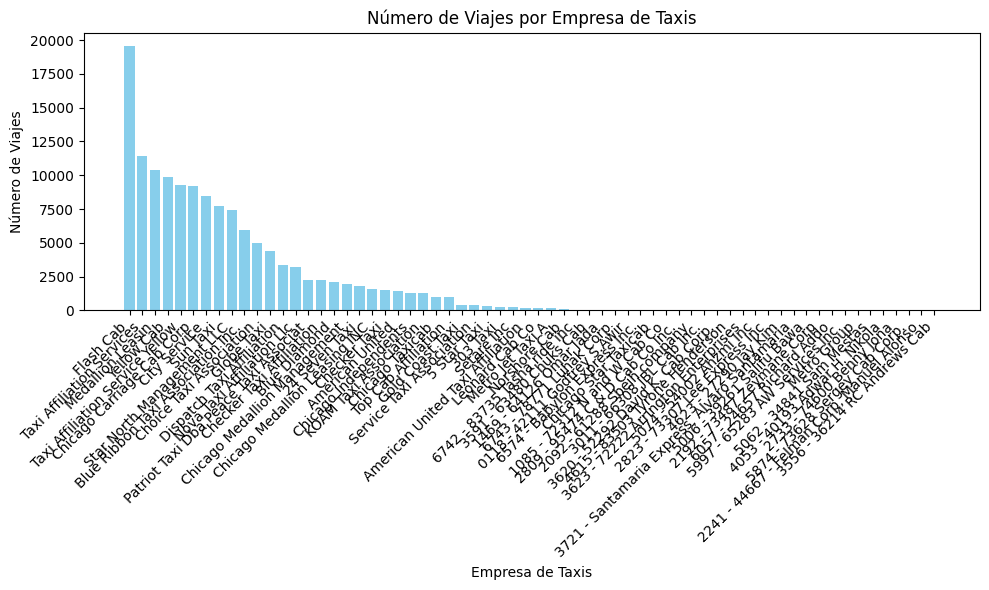

In [17]:
# Gráfico de empresas detaxi y numero de viajes

# Configuración del gráfico
plt.figure(figsize=(10, 6))
plt.bar(
    df_company_trips["company_name"], df_company_trips["trips_amount"], color="skyblue"
)
plt.xlabel("Empresa de Taxis")
plt.ylabel("Número de Viajes")
plt.title("Número de Viajes por Empresa de Taxis")
plt.xticks(
    rotation=45, ha="right"
)  # Rotamos las etiquetas del eje x para mejor legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()